In [18]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

pb.ion()

file_base = ""

In [19]:
X_orig = np.load("../../best_lhc_unit_G8_massive.npy", allow_pickle=True)
X_orig = X_orig[:100]
X_orig[:, 3]
sigma12s = np.sqrt(X_orig[:, 3] * 0.96 + 0.04)

In [20]:
len(sigma12s)

100

(array([ 5.,  3.,  5.,  9., 12., 16.,  8., 10., 16., 16.]),
 array([0.21503488, 0.29305506, 0.37107524, 0.44909541, 0.52711559,
        0.60513577, 0.68315595, 0.76117612, 0.8391963 , 0.91721648,
        0.99523666]),
 <BarContainer object of 10 artists>)

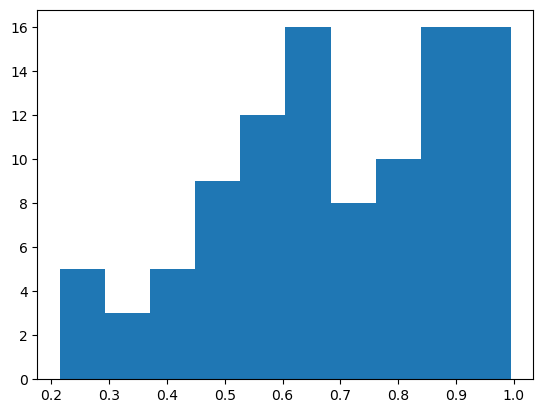

In [21]:
pb.hist(sigma12s)

In [22]:
#X_raw = np.load("G_versions/hc_G6_test.npy", allow_pickle=True)
#Y_raw = np.load("G_versions/samples_G6_test.npy", allow_pickle=True)
linear_in_sigma12 = False

if linear_in_sigma12:
    X_raw = np.load("hc_backup_i99_H3_unit_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i99_H3_unit_train.npy", allow_pickle=True)
else:
    # X_raw = np.load("hc_backup_i499_H2_train.npy", allow_pickle=True)
    # Y_raw = np.load("samples_backup_i499_H2_train.npy", allow_pickle=True)
    X_raw = np.load("hc_backup_i499_H3_unit_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i499_H3_unit_train.npy", allow_pickle=True)  

# Emulator version label, for plots
emu_vlabel = "H3"

In [23]:
scales = np.load("standard_k.npy", allow_pickle=True)

In [24]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [25]:
m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".cle", "rb"))

In [26]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [27]:
par_ranges = ui.get_param_ranges(massive_neutrinos=True)
xmin = np.array([])
xrange = np.array([])

for key in par_ranges.keys():
    xmin = np.append(xmin, par_ranges[key][0])
    xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])

# ! This is bad form, xmin and xrange should be saved with the emulator object
#def xtransform(configuration):
#    return (configuration - xmin) / xrange

def xtransform(configuration):
    return configuration

In [28]:
def nest(array):
    return np.array([np.array(array)])

In [29]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)
sq_errors = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    rel_errors[i] = (preds[i] - Y[i]) / Y[i]
    sq_errors[i] = np.square(preds[i] - Y[i])

In [30]:
print("Squared error across all models:")
print(sum(sum(sq_errors)))

Squared error across all models:
95989907090.85973


# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [31]:
min(X[:, 3])

0.0003000000415598076

In [32]:
max(X[:, 3])

0.9979036413426463

In [33]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

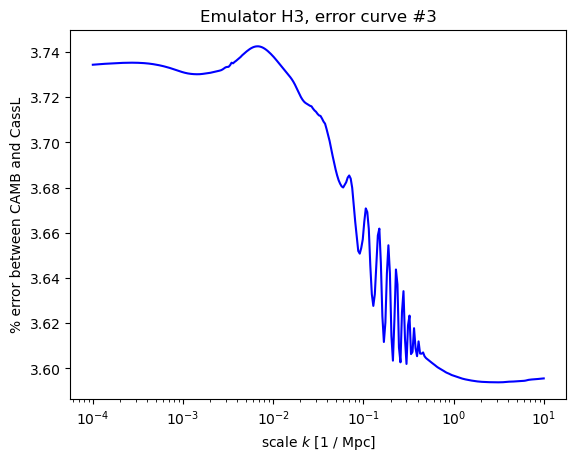

In [34]:
error_i = 3
pb.plot(scales, 100 * rel_errors[error_i], color='blue')
pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", error curve #" + str(error_i))
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G7a.png")

In [35]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, save_label=None):
    normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)

    for i in range(len(rel_errors)):
        if i % 1 == 0:
            pb.plot(scales, 100 * rel_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" + 
            "\ncolored by " + param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index]), vmax=max(X[:, param_index]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    if save_label is not None:
        pb.savefig("../plots/emulator/performance/" + save_label + ".png")

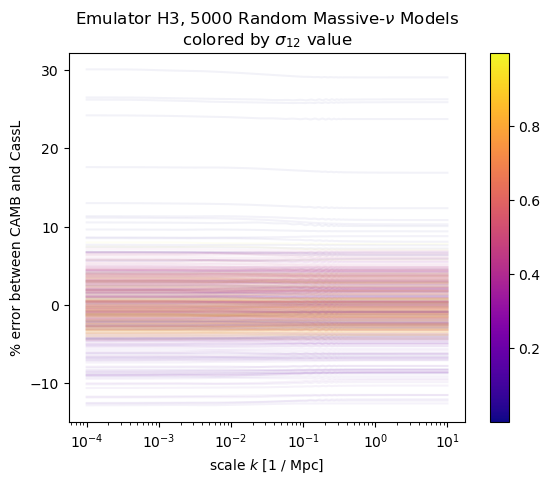

In [36]:
plot_colored_errors(3, r"$\sigma_{12}$", save_label="s12_coloration")

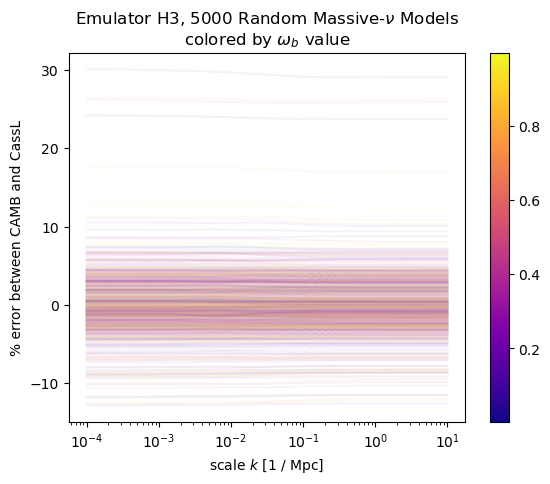

In [37]:
plot_colored_errors(0, r"$\omega_b$")

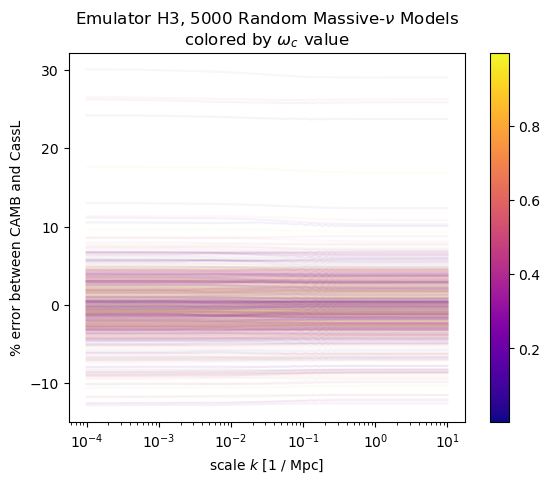

In [38]:
plot_colored_errors(1, r"$\omega_c$")

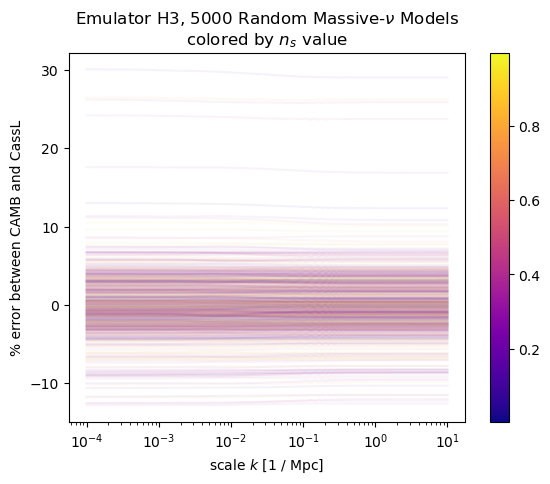

In [39]:
plot_colored_errors(2, r"$n_s$")

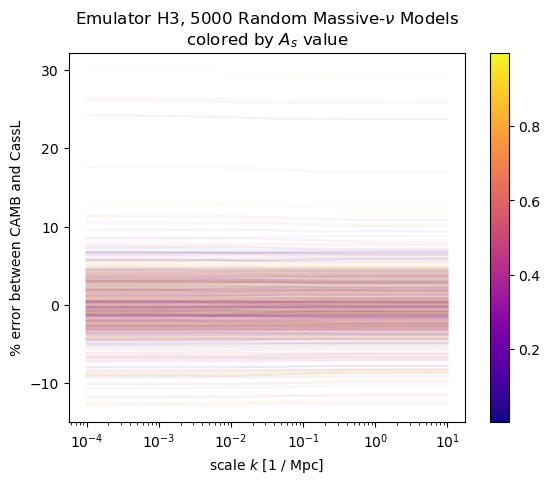

In [40]:
plot_colored_errors(4, r"$A_s$", "_colored_by_As")

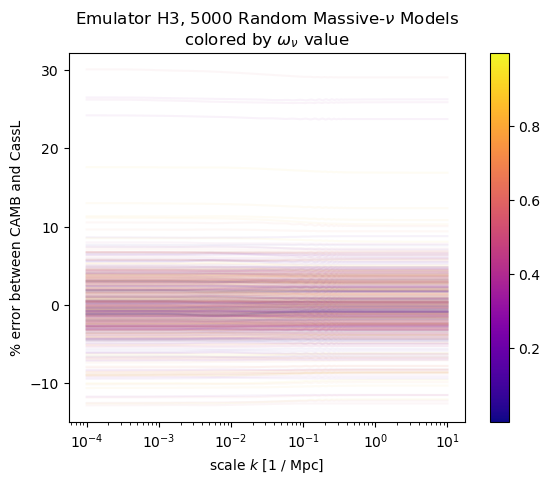

In [41]:
plot_colored_errors(5, r"$\omega_\nu$", "_colored_by_omnu")

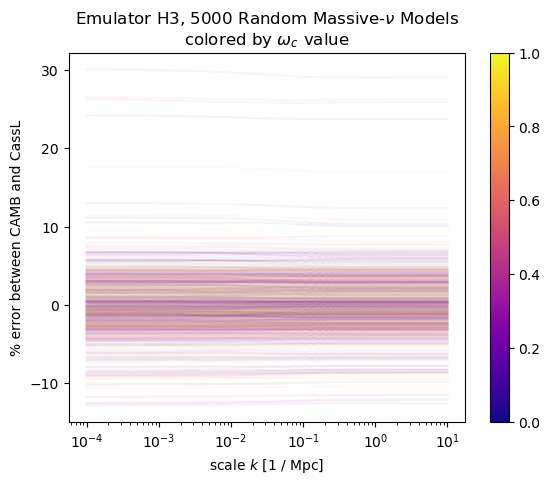

In [42]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

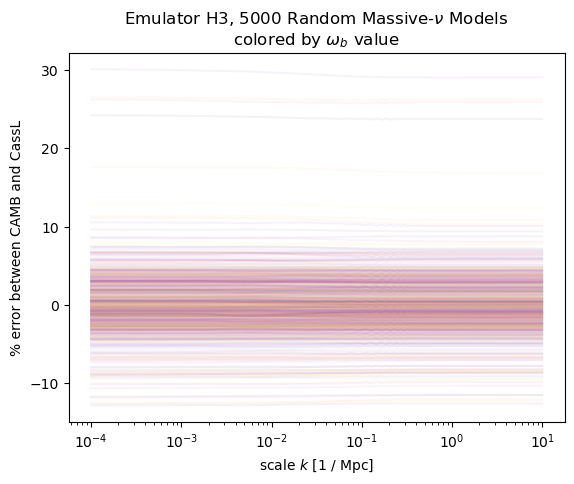

In [43]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

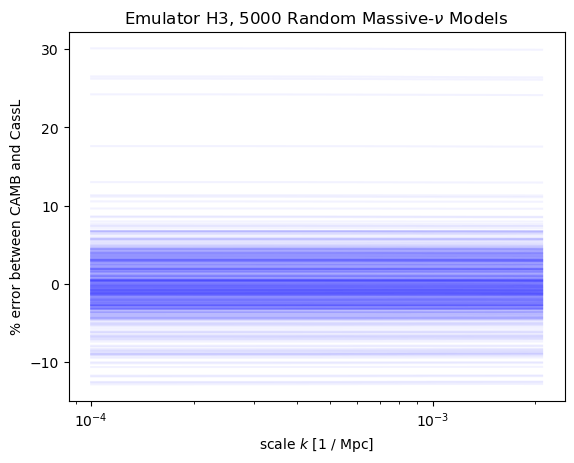

In [44]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

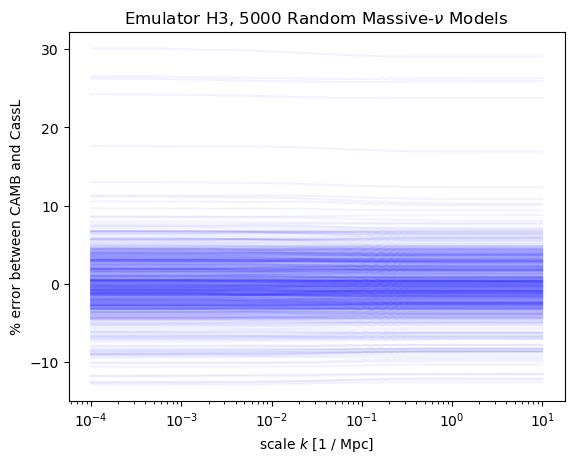

In [45]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../plots/emulator/performance/massive_5k_" + emu_vlabel + ".png")

In [46]:
# Error statistics ideas: parentheticals describe building blocks

# (for each curve:)
    # a minimum percent error
    # b maximum percent error
    # c standard deviation of errors
    # d mean error
    # e median error

# Median, mean, stddev of a-e.

mins = np.array([min(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MINIMUM RELATIVE ERRORS:")
print("this ranges from", min(mins), "to", max(mins))
print("median is", np.median(mins))
print("mean is", np.mean(mins))
print("st.dev. is", np.std(mins))

MINIMUM RELATIVE ERRORS:
this ranges from 7.540144948793462e-08 to 0.29062338905727847
median is 0.023163600837679696
mean is 0.030245644110871446
st.dev. is 0.03258681260985521


In [47]:
maxs = np.array([max(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MAXIMUM RELATIVE ERRORS:")
print("this ranges from", min(maxs), "to", max(maxs))
print("median is", np.median(maxs))
print("mean is", np.mean(maxs))
print("st.dev. is", np.std(maxs))

MAXIMUM RELATIVE ERRORS:
this ranges from 0.0002800265522052417 to 0.3009675863349544
median is 0.024966697599566778
mean is 0.032161501633102656
st.dev. is 0.03312739572699354


In [48]:
means = np.array([np.mean(rel_error_curve) for rel_error_curve in rel_errors])
print("MEAN RELATIVE ERRORS:")
print("this ranges from", min(means), "to", max(means))
print("median is", np.median(means))
print("mean is", np.mean(means))
print("st.dev. is", np.std(means))

MEAN RELATIVE ERRORS:
this ranges from -0.12694958034132076 to 0.29500026912175503
median is -0.0014232375040272383
mean is 0.000993950570314596
st.dev. is 0.045292827447775914


In [49]:
meds = np.array([np.median(rel_error_curve) for rel_error_curve in rel_errors])
print("MEDIAN RELATIVE ERRORS:")
print("this ranges from", min(meds), "to", max(meds))
print("median is", np.median(meds))
print("mean is", np.mean(meds))
print("st.dev. is", np.std(meds))

MEDIAN RELATIVE ERRORS:
this ranges from -0.12668229719965118 to 0.29403653070080726
median is -0.0013622607032108196
mean is 0.0009941918041892815
st.dev. is 0.0453091343704685


In [50]:
stddevs = np.array([np.std(rel_error_curve) for rel_error_curve in rel_errors])
print("ST.DEV.S IN RELATIVE ERRORS:")
print("this ranges from", min(stddevs), "to", max(stddevs))
print("median is", np.median(stddevs))
print("mean is", np.mean(stddevs))
print("st.dev. is", np.std(stddevs))

ST.DEV.S IN RELATIVE ERRORS:
this ranges from 5.9457020417574685e-05 to 0.004162774315774291
median is 0.0005154124096562998
mean is 0.0006614639862384255
st.dev. is 0.000504246064208323


(array([305., 133.,  41.,  12.,   4.,   1.,   0.,   0.,   3.,   1.]),
 array([7.54014495e-08, 2.90624068e-02, 5.81247381e-02, 8.71870695e-02,
        1.16249401e-01, 1.45311732e-01, 1.74374064e-01, 2.03436395e-01,
        2.32498726e-01, 2.61561058e-01, 2.90623389e-01]),
 <BarContainer object of 10 artists>)

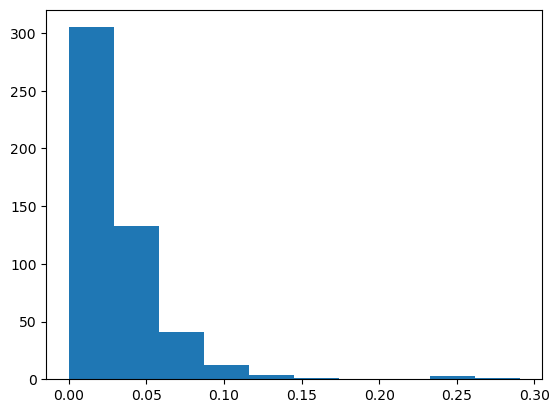

In [51]:
pb.hist(mins)

(array([300., 139.,  39.,  13.,   4.,   1.,   0.,   0.,   3.,   1.]),
 array([2.80026552e-04, 3.03487825e-02, 6.04175385e-02, 9.04862945e-02,
        1.20555050e-01, 1.50623806e-01, 1.80692562e-01, 2.10761318e-01,
        2.40830074e-01, 2.70898830e-01, 3.00967586e-01]),
 <BarContainer object of 10 artists>)

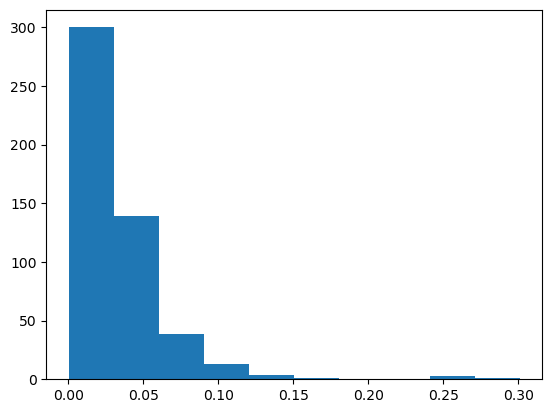

In [52]:
pb.hist(maxs)

(array([220., 158.,  72.,  27.,  17.,   2.,   1.,   1.,   1.,   1.]),
 array([5.94570204e-05, 4.69788750e-04, 8.80120479e-04, 1.29045221e-03,
        1.70078394e-03, 2.11111567e-03, 2.52144740e-03, 2.93177913e-03,
        3.34211086e-03, 3.75244259e-03, 4.16277432e-03]),
 <BarContainer object of 10 artists>)

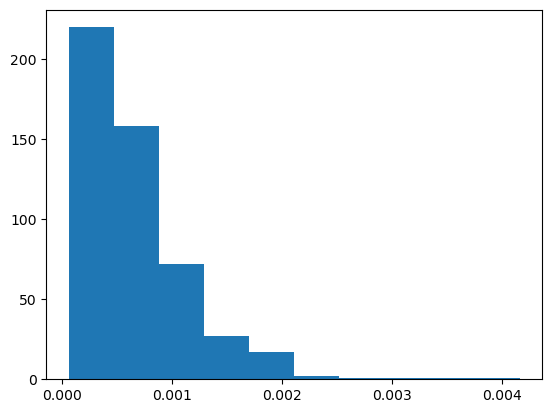

In [53]:
pb.hist(stddevs)

(array([ 18.,  34., 202., 189.,  45.,   6.,   1.,   1.,   1.,   3.]),
 array([-0.1266823 , -0.08461041, -0.04253853, -0.00046665,  0.04160523,
         0.08367712,  0.125749  ,  0.16782088,  0.20989277,  0.25196465,
         0.29403653]),
 <BarContainer object of 10 artists>)

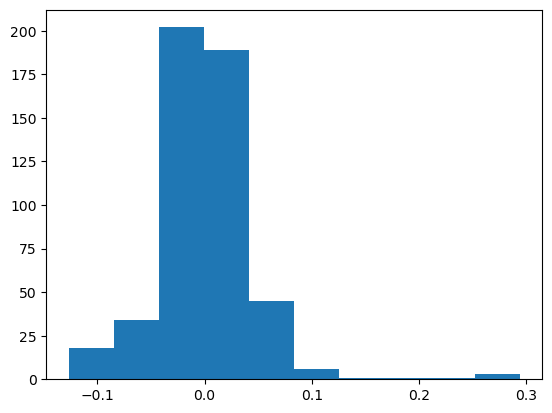

In [54]:
pb.hist(meds)

(array([ 16.,  36., 203., 189.,  45.,   5.,   1.,   1.,   1.,   3.]),
 array([-0.12694958, -0.0847546 , -0.04255961, -0.00036463,  0.04183036,
         0.08402534,  0.12622033,  0.16841531,  0.2106103 ,  0.25280528,
         0.29500027]),
 <BarContainer object of 10 artists>)

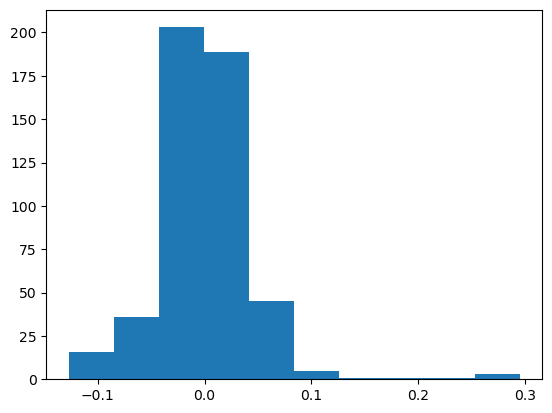

In [55]:
pb.hist(means)